In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import imageio

from unityagents import UnityEnvironment

from inspect import getsource
import torch
import random
from collections import deque

import colorsys

from drl_nav.agent import Agent_PER

In [2]:
path_model = r'./model'
path_result = r'./result'

____

### Environment exploration.

In [4]:
banana_path= r"environment/VisualBanana_Windows_x86_64/Banana.exe"
visual_banana_path= r"environment/VisualBanana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=visual_banana_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 84, 84, 3)
States look like:


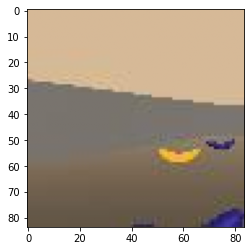

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
state_size = state.shape
print('States have shape:', state.shape)
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()

__________

### Creation of a tool that help image training by producing labels.

- [ ] pooling the image not to take into account distant bananas.
- [ ] converting the image from RGB to HSV in order to make the 3 image dimensions independent and thus allowing color detection.
- [ ] checking Hue range in HSV.
- [ ] Separation the image and produced label according to the direction.

In [6]:
from torch import nn
import torch.nn.functional as F

class ConvBody(nn.Module):
    """
    _summary_

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self):
        super(ConvBody, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5)
        self.mp1 = nn.MaxPool2d(kernel_size=3, stride=3)

    def forward(self, input):
        
        conv = self.conv1(input)
        conv_act = F.relu(conv)
        mp = self.mp1(conv_act)

        return mp
    
class AuxNet(nn.Module):
    
    def __init__(self):
        super(AuxNet, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=6, stride=2)
    
    def forward(self, x):
        return self.avg_pool(x)

#### Preprocessing with auxiliary network.

from


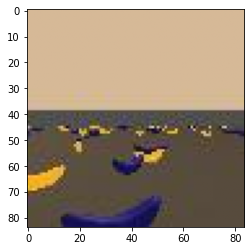

In [12]:
print('from')
plt.imshow(np.squeeze(state));

into


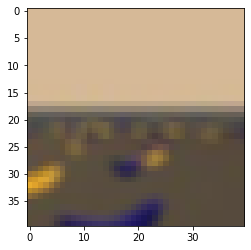

In [13]:
net = ConvBody()
aux_net= AuxNet()

state_torch = torch.from_numpy(np.squeeze(state).T).float()

output = aux_net(state_torch)
output_rgb = output.numpy().T

print('into')
plt.imshow(output_rgb);

#### Colored bananas detection.

In [36]:
output_rgb.shape # 20 * 20 pixels RGB size 3

(40, 40, 3)

##### Converting RGB to HSV images.

In [12]:
def rgb_to_hsv(args):
    '''convert a rgb pixel into a hsv pixel'''
    return colorsys.rgb_to_hsv(*args)
def hsv_to_rgb(args):
    '''convert a hsv pixel into a rgb pixel'''
    return colorsys.hsv_to_rgb(*args)

Checks:

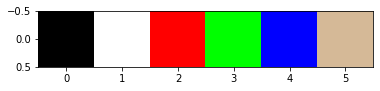

In [8]:
# test image
x_RGB = np.array([
    [
        [0.,0.,0.],
        [1.,1.,1.],
        [1.,0.,0.],
        [0.,1.,0.],
        [0.,0.,1.],
        [0.8392152 , 0.72549045, 0.59215695]
    ]
])

plt.imshow(x_RGB);

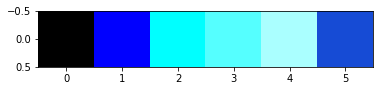

In [11]:
# to HSV
x_HSV = np.apply_along_axis(rgb_to_hsv, 2, x_RGB)
plt.imshow(x_HSV);

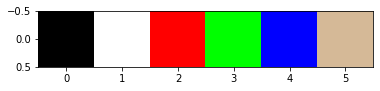

In [12]:
# back to RGB
x_RBG_back = np.apply_along_axis(hsv_to_rgb, 2, x_HSV)
plt.imshow(x_RBG_back)

##### Finding the Hue range

In [5]:
def plot_hue_color_range(hue_range, nbr_points=11):
    """
    plot the colors between the given min and max hue.
    """
    
    min_hue, max_hue = hue_range
    hues = np.linspace(min_hue, max_hue, nbr_points)
    x_HSV = np.expand_dims([[hue, .9, .9] for hue in hues], axis=0)
    x_RGB = np.apply_along_axis(hsv_to_rgb, 2, x_HSV)
    
    _, ax = plt.subplots(1,1)
    img = ax.imshow(x_RGB)
    ax.set_xticks(np.linspace(0, len(hues)-1, len(hues)))
    ax.set_xticklabels(np.round(hues, 2));
    ax.set_yticklabels('');

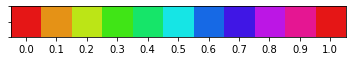

In [9]:
plot_hue_color_range((0,1))

Finding yellow and blue:

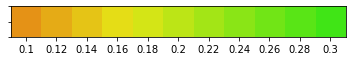

In [10]:
plot_hue_color_range((0.1,.3))

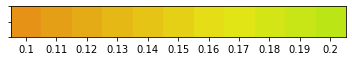

In [11]:
plot_hue_color_range((0.1,.2))

yellow range => [0.1, 0.2]

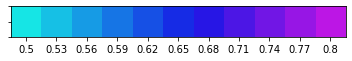

In [12]:
plot_hue_color_range((.5,.8))

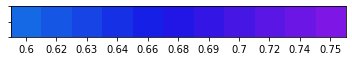

In [13]:
plot_hue_color_range((.6, .75))

blue range => [0.55, 0.7]

In [23]:
def is_yellow(hsv):
    hue = hsv[0]
    return (.11 <= hue) & (hue <= .2)

def is_blue(hsv):
    hue = hsv[0]
    return (.6 <= hue) & (hue <= .7)

##### Checks and adjustments.

In [20]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]

state_rgb =  np.squeeze(state)
state_hsv = np.apply_along_axis(rgb_to_hsv, 2, state_rgb)

state_torch = torch.from_numpy(np.squeeze(state).T).float()
output = aux_net(state_torch)

output_rgb = output.numpy().T
output_hsv = np.apply_along_axis(rgb_to_hsv, 2, output_rgb)

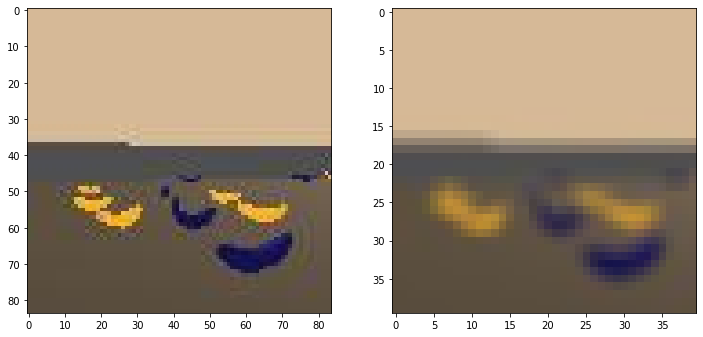

In [21]:
_, (ax1, ax2) = plt.subplots(1,2, figsize = (12,10))

ax1.imshow(state_rgb)
ax2.imshow(output_rgb)

plt.show()

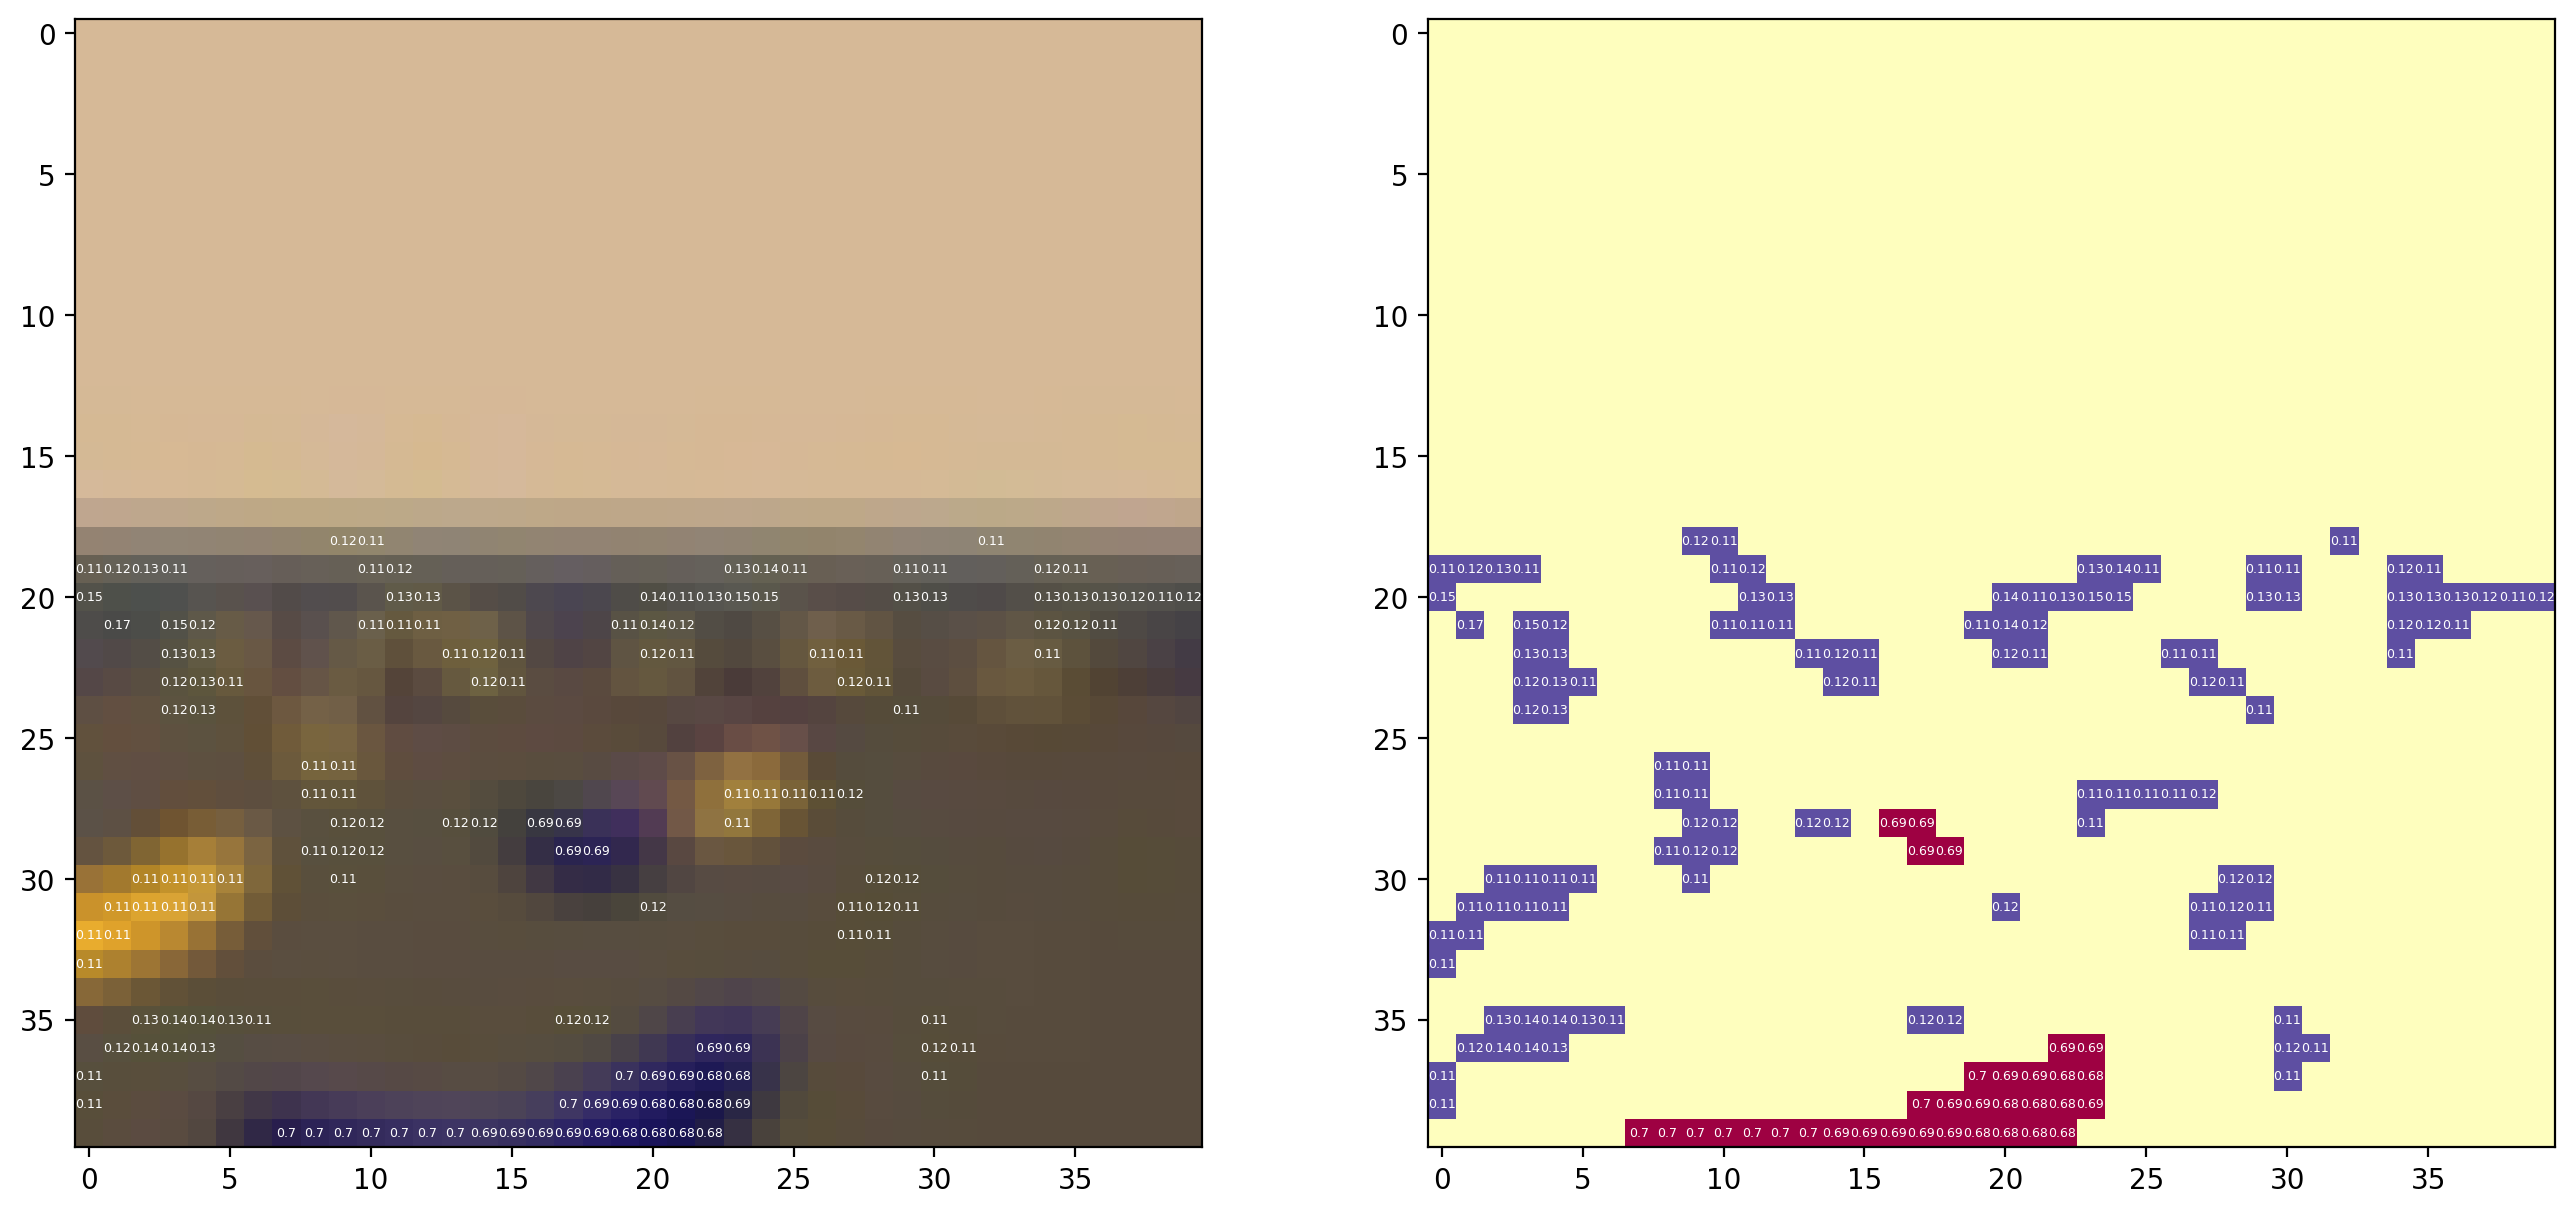

In [75]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)

ax1.imshow(output_rgb)
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 2),
                     ha="center", va="center", color="w", fontsize=4.5)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 2),
                     ha="center", va="center", color="w", fontsize=4.5)

plt.show()

-> Yellow is not working, analyzing the different hues.

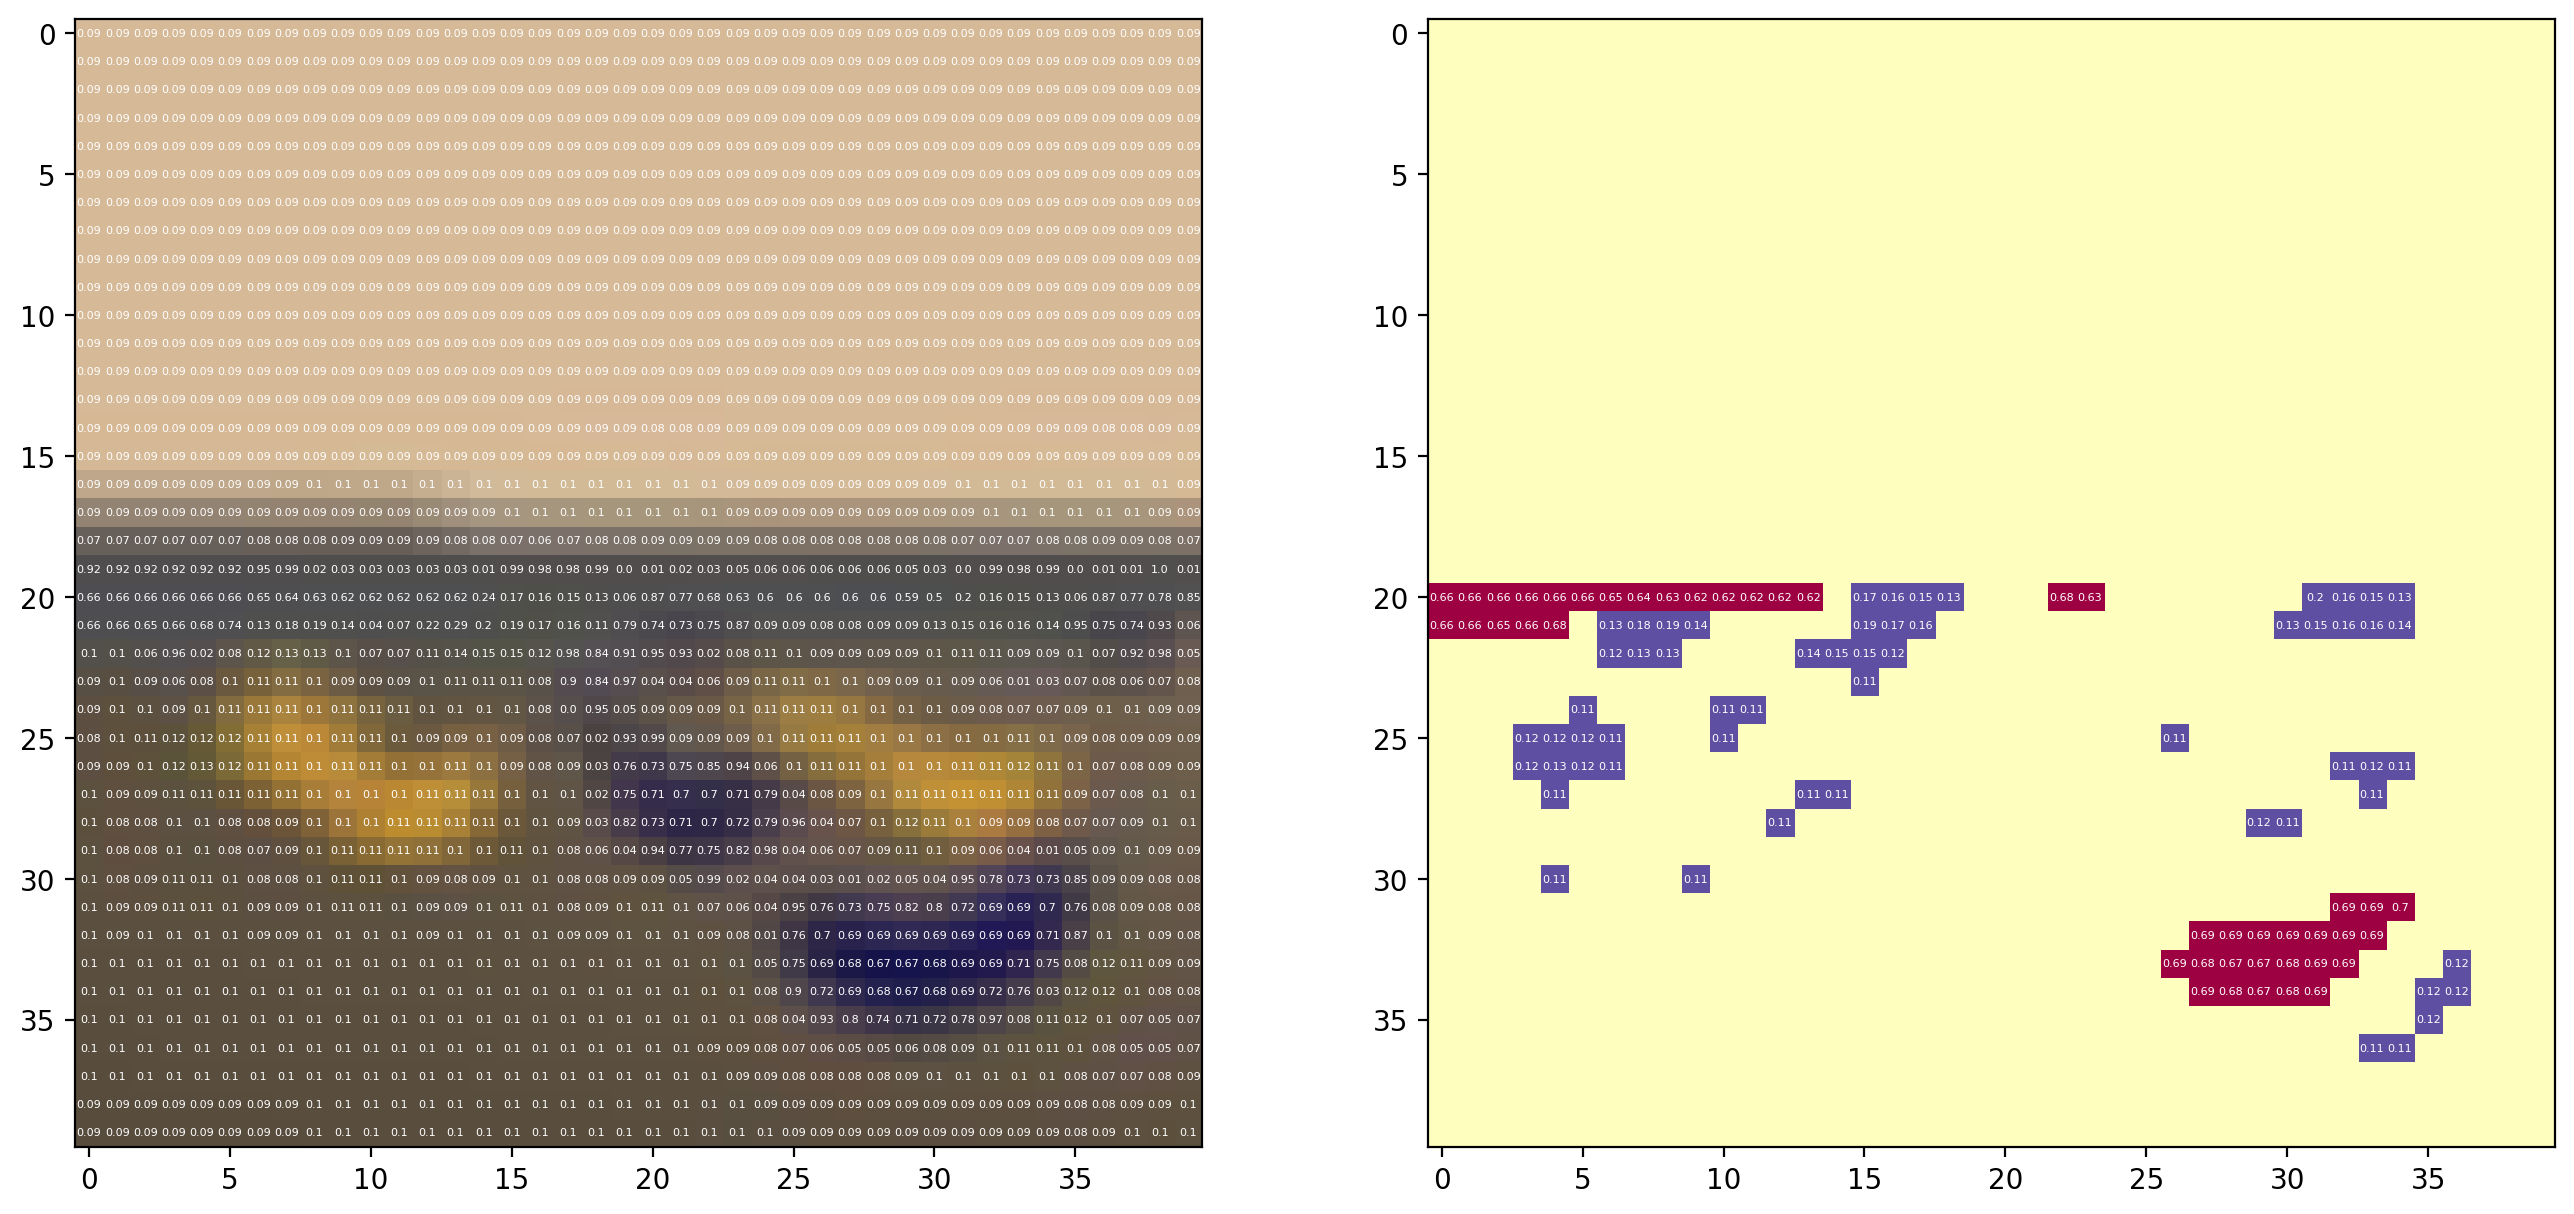

In [24]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)
ax1.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 2),
                     ha="center", va="center", color="w", fontsize=4)

ax1.imshow(output_rgb)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 2),
                     ha="center", va="center", color="w", fontsize=4)

plt.show()

Analyzing HSV data on a yellow sample to find complementary characteristics.

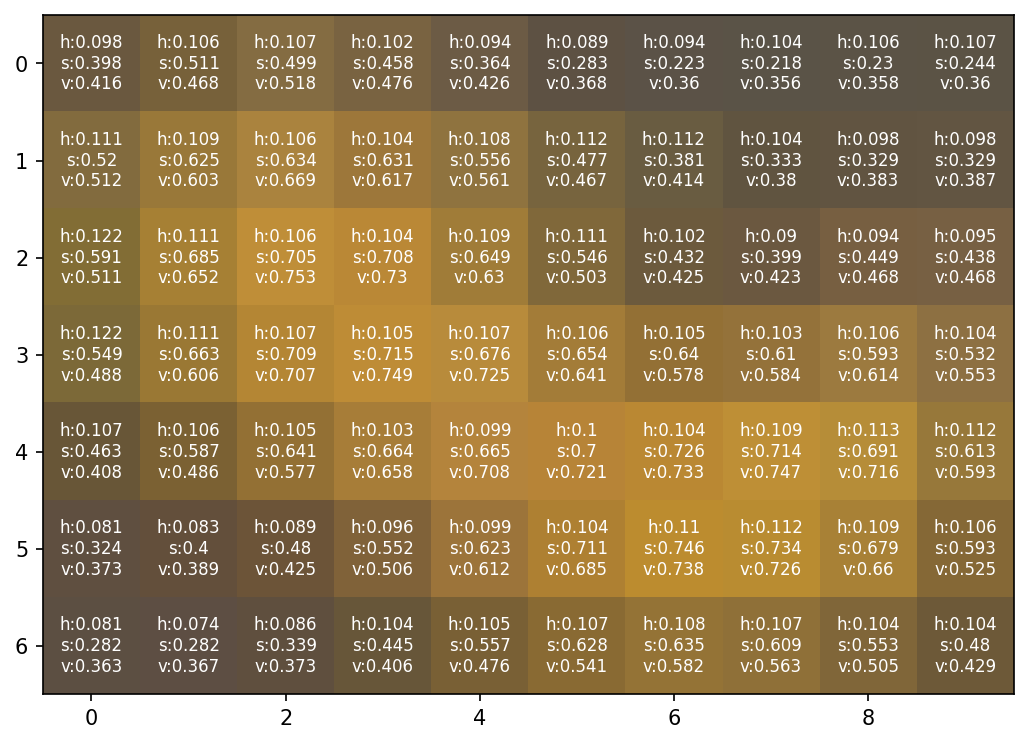

In [29]:
_, ax = plt.subplots(1,1, figsize = (10,6), dpi=150)

yellows_sample_rgb = output_rgb[23:30, 5:15]
yellows_sample_hsv = state_hsv = np.apply_along_axis(rgb_to_hsv, 2, yellows_sample_rgb)

ax.imshow(yellows_sample_rgb)

for i in range(yellows_sample_rgb.shape[0]):
    for j in range(yellows_sample_rgb[i].shape[0]):
        ax.text(j, i, 
                (f'h:{np.round(yellows_sample_hsv[i, j, 0], 3)}\n'+
                 f's:{np.round(yellows_sample_hsv[i, j, 1], 3)}\n'+
                 f'v:{np.round(yellows_sample_hsv[i, j, 2], 3)}'),
                ha="center", va="center", color="w", fontsize=8)
plt.show()

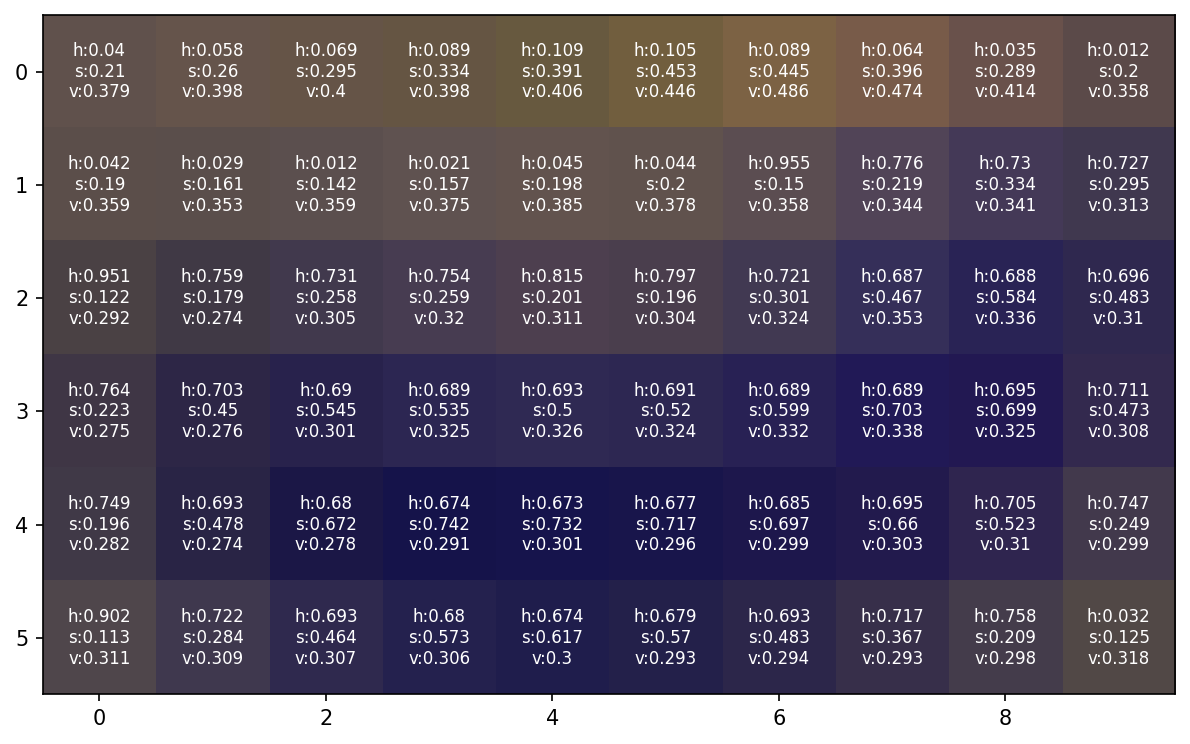

In [31]:
_, ax = plt.subplots(1,1, figsize = (10,6), dpi=150)

yellows_sample_rgb = output_rgb[29:35, 25:35]
yellows_sample_hsv = state_hsv = np.apply_along_axis(rgb_to_hsv, 2, yellows_sample_rgb)

ax.imshow(yellows_sample_rgb)

for i in range(yellows_sample_rgb.shape[0]):
    for j in range(yellows_sample_rgb[i].shape[0]):
        ax.text(j, i, 
                (f'h:{np.round(yellows_sample_hsv[i, j, 0], 3)}\n'+
                 f's:{np.round(yellows_sample_hsv[i, j, 1], 3)}\n'+
                 f'v:{np.round(yellows_sample_hsv[i, j, 2], 3)}'),
                ha="center", va="center", color="w", fontsize=8)
plt.show()

Is_color adjustments.

In [7]:
def is_yellow(hsv):
    '''determine is the given hsv pixel is yellow'''
    hue = hsv[0]
    sat = hsv[1]
    val = hsv[2]
    
    hue_ok = ((.105 <= hue) & (hue <= .2))
    sat_ok = .6 <= sat
    val_ok = .6 <= val
    
    return hue_ok & sat_ok & val_ok

def is_blue(hsv):
    '''determine is the given hsv pixel is blue'''
    hue = hsv[0]
    sat = hsv[1]
    val = hsv[2]
    
    hue_ok = ((.6 <= hue) & (hue <= .75))
    sat_ok = .2 <= sat
    val_ok = .3 <= val

    return hue_ok & sat_ok & val_ok

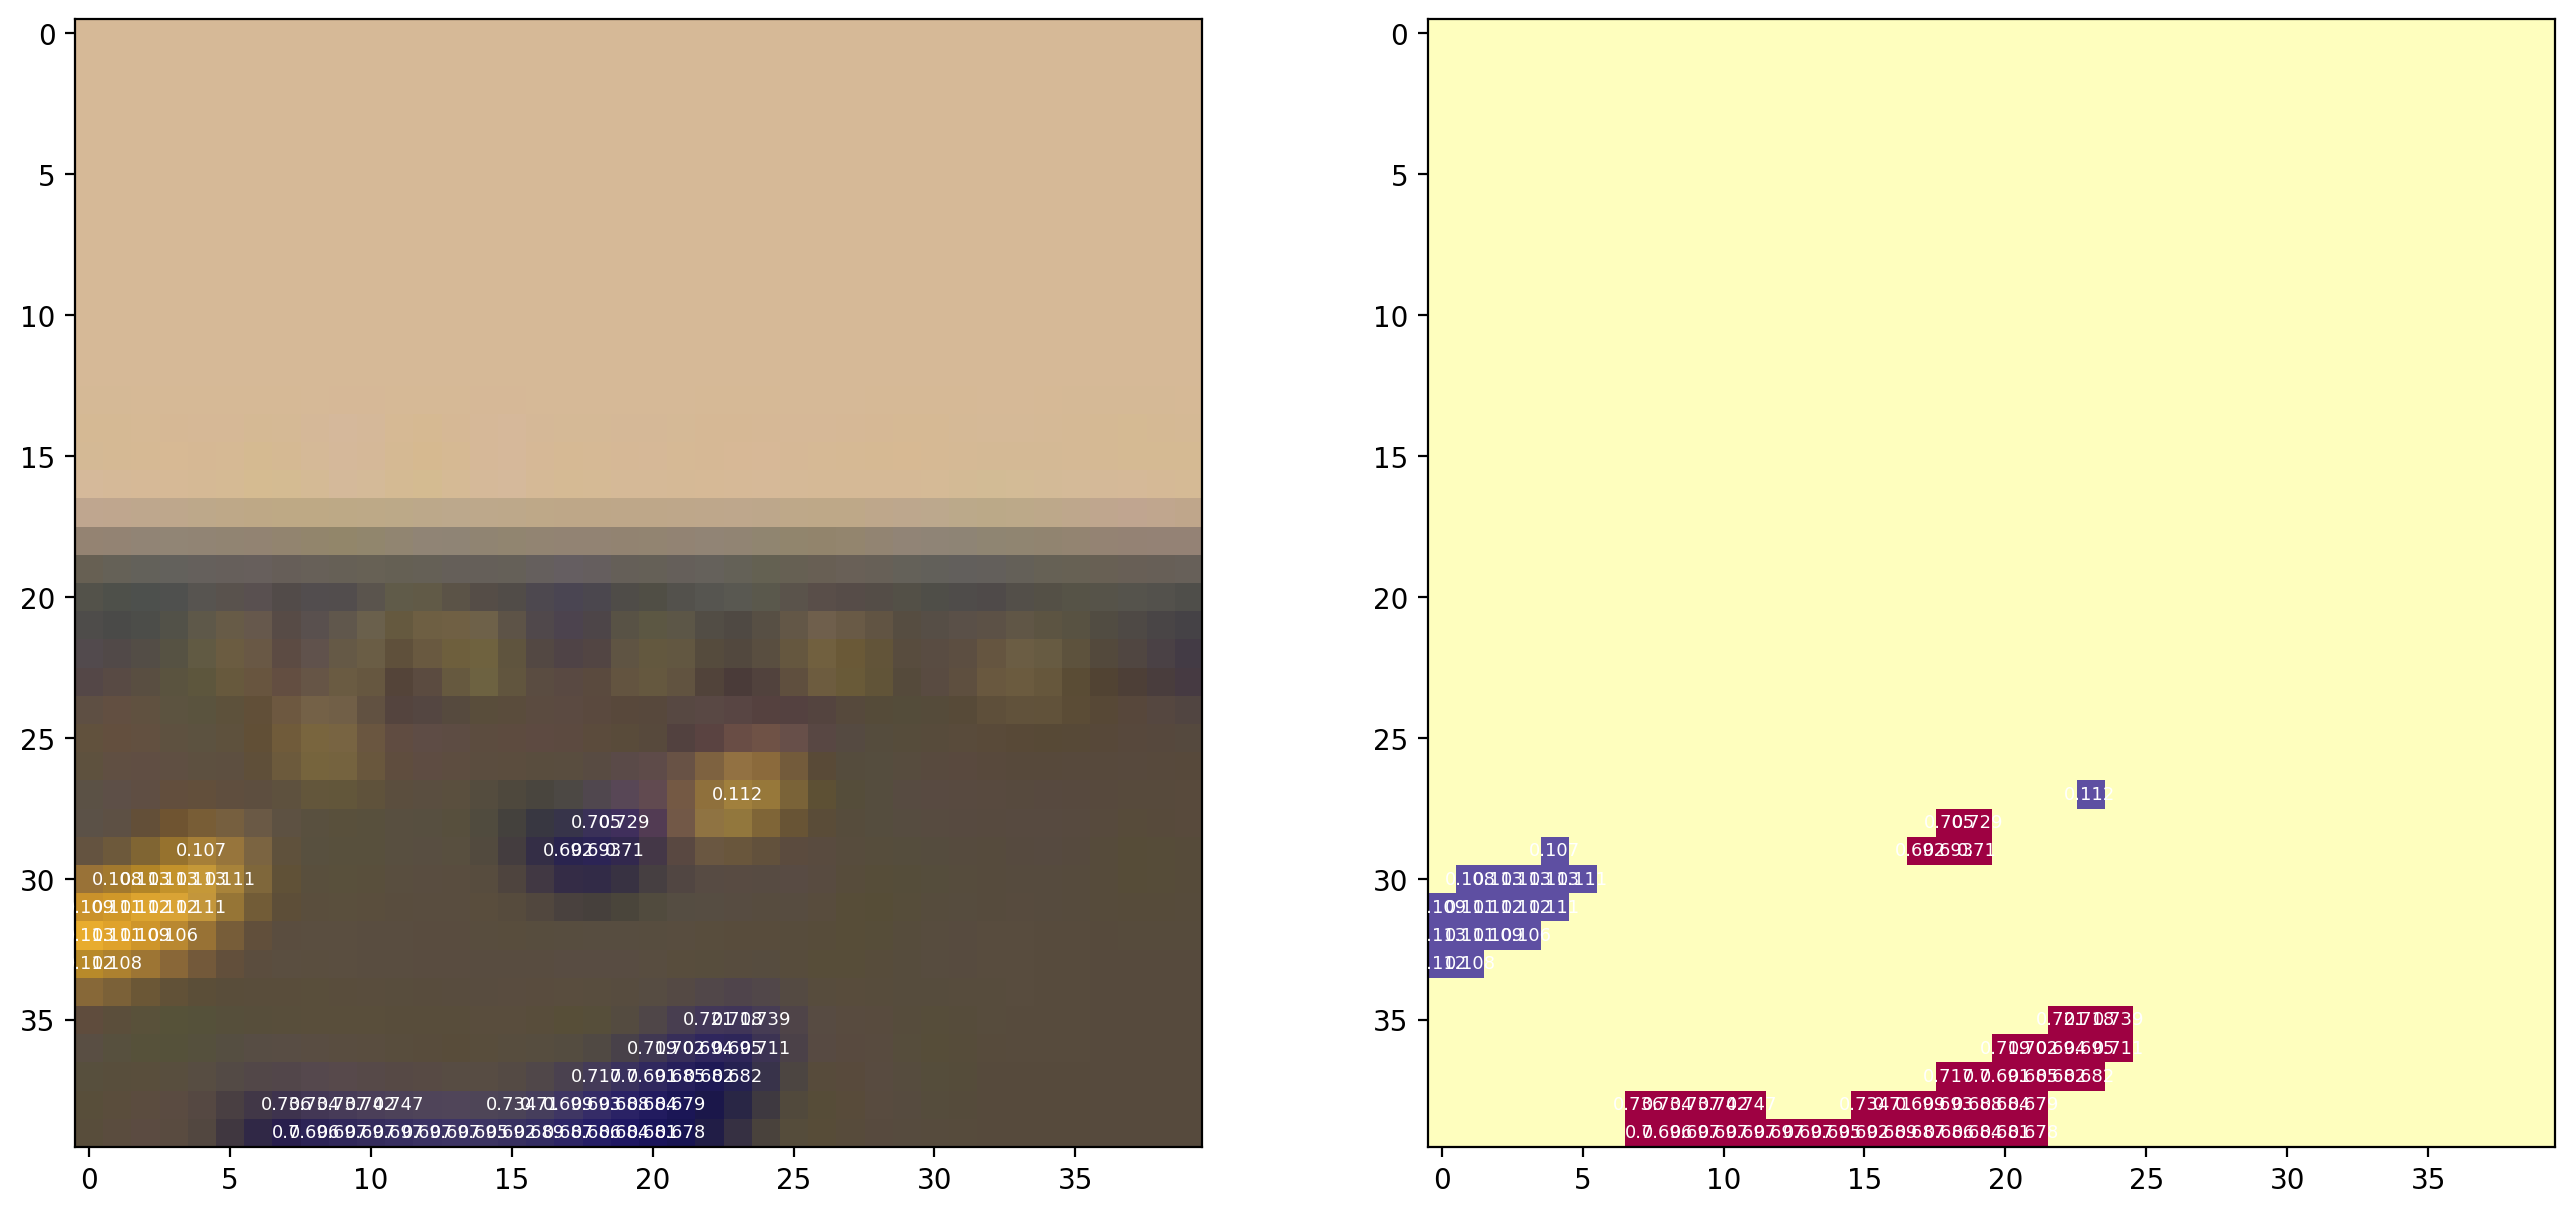

In [80]:
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)

_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,14), dpi=200)

ax1.imshow(output_rgb)
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax1.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

ax2.imshow(mask_bananas, cmap='Spectral')
for i in range(output_hsv.shape[0]):
    for j in range(output_hsv[i].shape[0]):
        if mask_bananas[i, j] != 0:
            ax2.text(j, i, np.round(output_hsv[i, j, 0], 3),
                     ha="center", va="center", color="w", fontsize=6.5)

plt.show()

##### Finding bananas on three different panels.

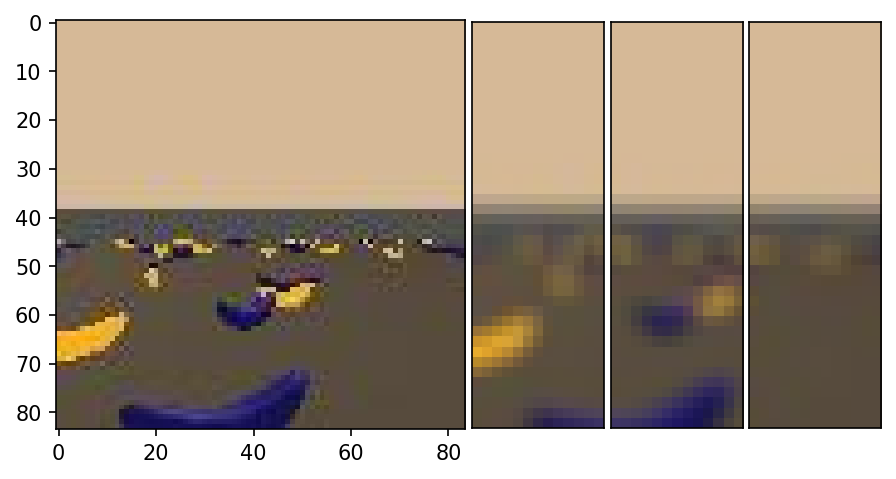

In [153]:
fig = plt.figure(constrained_layout=False, figsize=(10,5), dpi=150)
gs = fig.add_gridspec(nrows=1, ncols=6, left=0.05, right=0.60, wspace=0.05)

ax = fig.add_subplot(gs[:, :3])
ax_left = fig.add_subplot(gs[:,3])
ax_middle = fig.add_subplot(gs[:,4])
ax_right =fig.add_subplot(gs[:,5])

ax.imshow(state_rgb)

boundaries = [output_rgb.shape[1]//3 * i for i in range(4)]

for lower_bound, higher_bound, ax_direction in zip(boundaries[:-1], boundaries[1:], (ax_left, ax_middle, ax_right)):
    ax_direction.imshow(output_rgb[:, lower_bound: higher_bound])
    ax_direction.set_xticks([])
    ax_direction.set_yticks([])
    
plt.show();

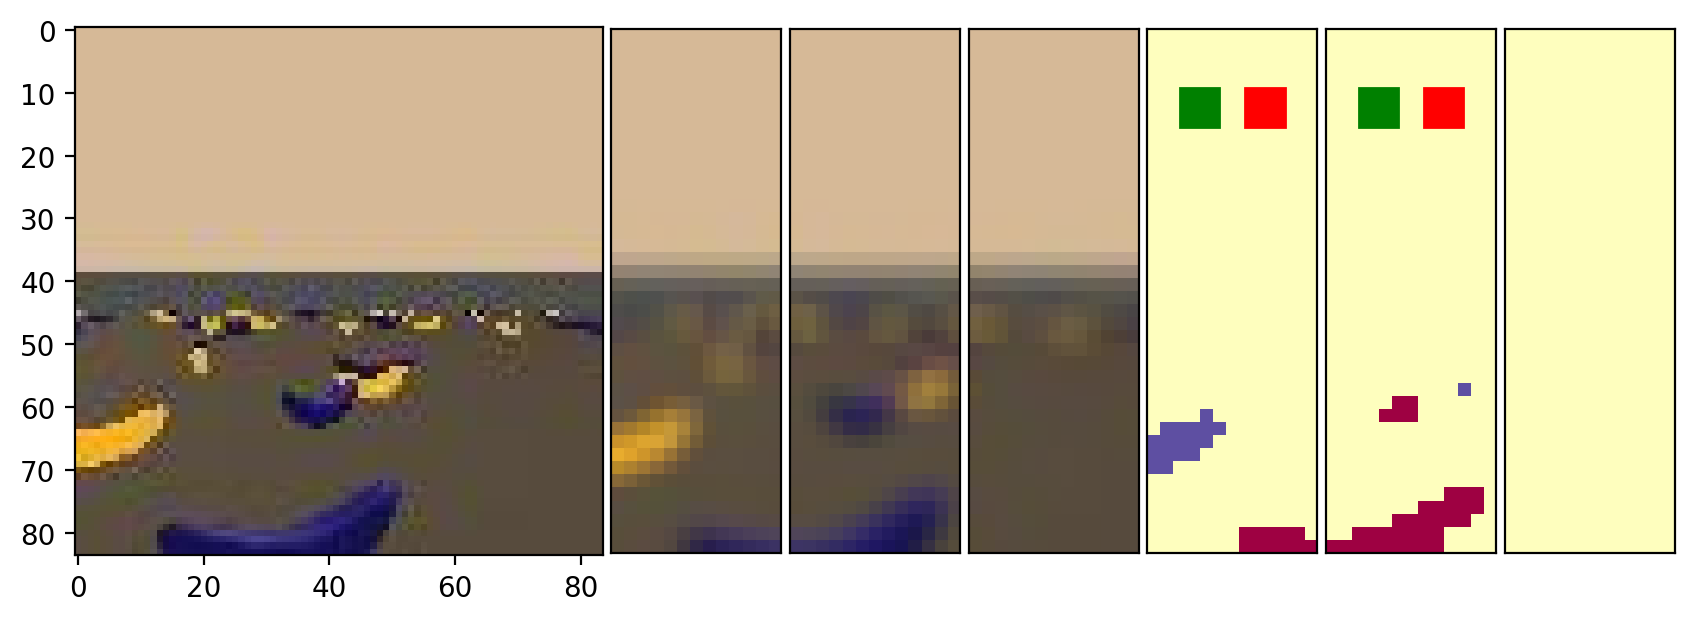

In [181]:
fig = plt.figure(constrained_layout=False, figsize=(10,5), dpi=200)
gs = fig.add_gridspec(nrows=1, ncols=9, left=0.05, right=0.85, wspace=0.05)

ax = fig.add_subplot(gs[:, :3])

ax.imshow(state_rgb)

boundaries = [output_rgb.shape[1]//3 * i for i in range(4)]

for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
    ax_output = fig.add_subplot(gs[:, 3 + idx])
    ax_output.imshow(output_rgb[:, lower_bound: higher_bound])
    ax_output.set_xticks([])
    ax_output.set_yticks([])
    
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)
    
for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
    ax_mask = fig.add_subplot(gs[:, 6 + idx])
    
    img = mask_bananas[:, lower_bound: higher_bound] 
    if np.max(img) == 1:
        rect = patches.Rectangle((2, 4), 3, 3, linewidth=1, edgecolor='g', facecolor='g')
        ax_mask.add_patch(rect)
    if np.min(img) == -1:
        rect = patches.Rectangle((7, 4), 3, 3, linewidth=1, edgecolor='r', facecolor='r')
        ax_mask.add_patch(rect)
        
    ax_mask.imshow(img, cmap='Spectral', vmin=-1, vmax=1) 
    ax_mask.set_xticks([])
    ax_mask.set_yticks([])
    
plt.show();

##### Creation of a gif

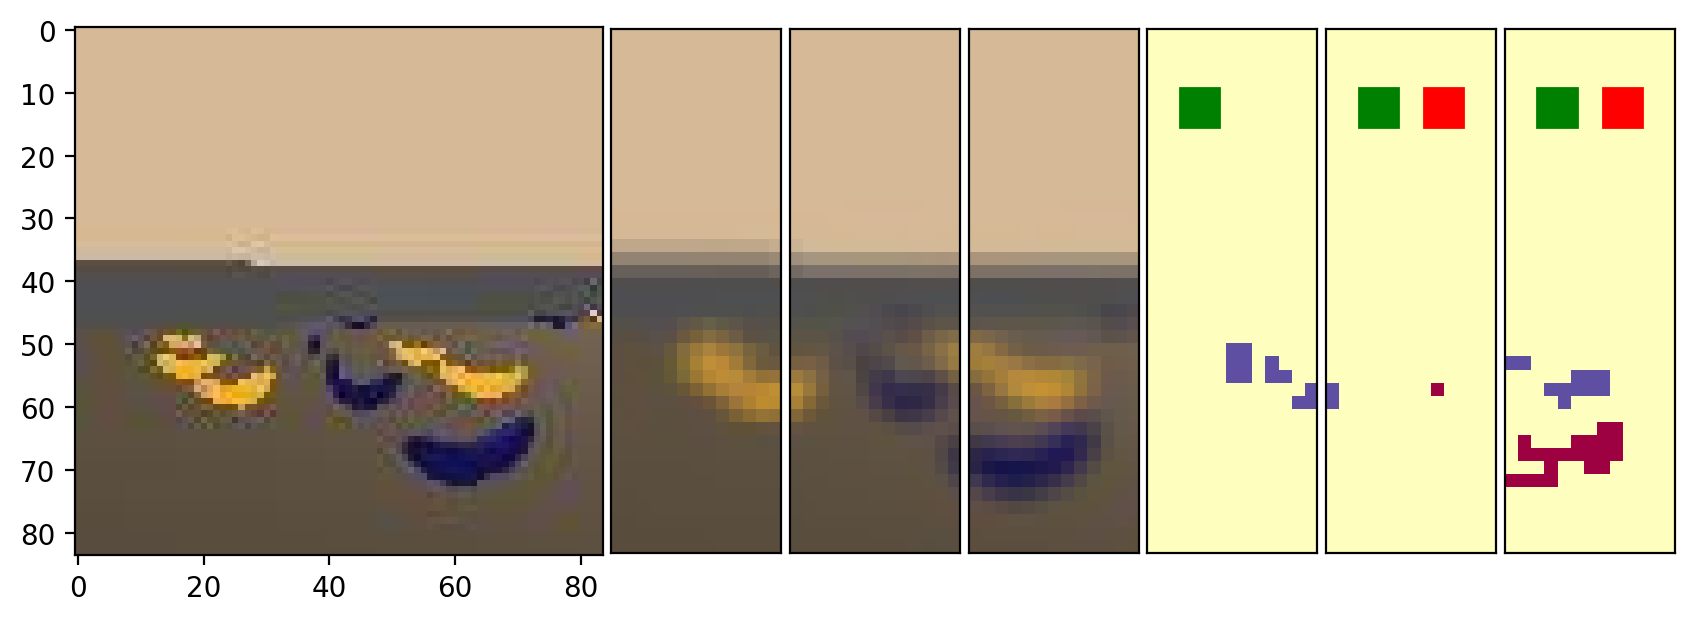

In [33]:
fig = plt.figure(constrained_layout=False, figsize=(10,5), dpi=200)
gs = fig.add_gridspec(nrows=1, ncols=9, left=0.05, right=0.85, wspace=0.05)

ax = fig.add_subplot(gs[:, :3])

ax.imshow(state_rgb)

boundaries = [output_rgb.shape[1]//3 * i for i in range(4)]

for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
    ax_output = fig.add_subplot(gs[:, 3 + idx])
    ax_output.imshow(output_rgb[:, lower_bound: higher_bound])
    ax_output.set_xticks([])
    ax_output.set_yticks([])
    
mask_bananas = (
    np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
    np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
)
    
for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
    ax_mask = fig.add_subplot(gs[:, 6 + idx])
    
    img = mask_bananas[:, lower_bound: higher_bound] 
    if np.max(img) == 1:
        rect = patches.Rectangle((2, 4), 3, 3, linewidth=1, edgecolor='g', facecolor='g')
        ax_mask.add_patch(rect)
    if np.min(img) == -1:
        rect = patches.Rectangle((7, 4), 3, 3, linewidth=1, edgecolor='r', facecolor='r')
        ax_mask.add_patch(rect)
        
    ax_mask.imshow(img, cmap='Spectral', vmin=-1, vmax=1) 
    ax_mask.set_xticks([])
    ax_mask.set_yticks([])
    
plt.show();

In [8]:
def create_ouptut_images(state):
    """
    Create state representations required to create the desired output image.
    """
    state_rgb =  np.squeeze(state)
    
    state_torch = torch.from_numpy(np.squeeze(state).T).float()
    output = aux_net(state_torch)
    
    output_rgb = output.numpy().T
    output_hsv = np.apply_along_axis(rgb_to_hsv, 2, output_rgb)
    
    return state_rgb, output_rgb, output_hsv

def generate_auxiliarynet_image(state_rgb, output_rgb, output_hsv, step=0, plot=True, save_directory=None):
    """
    Create an image composed of three panel:
        1. real state.
        2. state compressed by the auxiliary nework.
        3. banana detection.
    """

    fig = plt.figure(constrained_layout=False, figsize=(10,5), dpi=200)
    gs = fig.add_gridspec(nrows=1, ncols=9, left=0.05, right=0.85, wspace=0.05)
    
    ax = fig.add_subplot(gs[:, :3])
    
    ax.imshow(state_rgb)
    
    boundaries = [output_rgb.shape[1]//3 * i for i in range(4)]
    
    for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
        ax_output = fig.add_subplot(gs[:, 3 + idx])
        ax_output.imshow(output_rgb[:, lower_bound: higher_bound])
        ax_output.set_xticks([])
        ax_output.set_yticks([])
        
    mask_bananas = (
        np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
        np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
    )
        
    for lower_bound, higher_bound, idx in zip(boundaries[:-1], boundaries[1:], range(3)):
        ax_mask = fig.add_subplot(gs[:, 6 + idx])
        
        img = mask_bananas[:, lower_bound: higher_bound] 
        if np.max(img) == 1:
            rect = patches.Rectangle((2, 4), 3, 3, linewidth=1, edgecolor='g', facecolor='g')
            ax_mask.add_patch(rect)
        if np.min(img) == -1:
            rect = patches.Rectangle((7, 4), 3, 3, linewidth=1, edgecolor='r', facecolor='r')
            ax_mask.add_patch(rect)
            
        ax_mask.imshow(img, cmap='Spectral', vmin=-1, vmax=1) 
        ax_mask.set_xticks([])
        ax_mask.set_yticks([])
    

    if save_directory:
        plt.savefig(os.path.join(save_directory, f'img_{step}.png'))
    if plot:
        plt.show();
    plt.close('all')
    
def select_action(last_action, epsilon=0.75):
    """
    Exploratory action selection strategy that favor forward motion and action conservation.
    Actions explanation:
    0: forward
    1: backward
    2: left
    3: right
    """
    if np.random.random() > epsilon:
        action = np.random.choice([0, 1, 2, 3], p=[.5, .1, .2, .2])
    else:
        action = last_action
        
    return action

__________
### Recording of an episode as a GIF.

In [16]:
PATH_OUPUT_IMAGE = './output/image'
PATH_OUPUT_GIF = './output/gif'

In [51]:
# Clear files.

files_img = [file for file in os.listdir(PATH_OUPUT_IMAGE) if file.endswith(".png")]
for f in files_img:
    os.remove(os.path.join(PATH_OUPUT_IMAGE, f))
    
files_gif = [file for file in os.listdir(PATH_OUPUT_GIF) if file.endswith(".gif")]
for f in files_gif:
    if '_good' in f:
        continue
    os.remove(os.path.join(PATH_OUPUT_GIF, f))

__________
#### One episode

In [47]:
%%time

aux_net= AuxNet()

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score = 0   
step = 0
last_action = 0

while True:
    
    state_rgb, output_rgb, output_hsv = create_ouptut_images(state)
    generate_auxiliarynet_image(state_rgb, output_rgb, output_hsv, step, plot=False, save_directory=PATH_OUPUT_IMAGE)

    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

Score: 0.0
Wall time: 56.8 s


In [48]:
%%time

# gif creation.

files_img = [file for file in os.listdir(PATH_OUPUT_IMAGE) if file.endswith(".png")]
files_img.sort(key= lambda x: int(x.split('_')[1].split('.')[0]))

imgs = []
for file_img in files_img:
    imgs.append(imageio.imread(os.path.join(PATH_OUPUT_IMAGE, file_img)))

Wall time: 4.72 s


In [49]:
%%time

# gif save.

imageio.mimsave(os.path.join(PATH_OUPUT_GIF, 'vision.gif'), imgs, duration=.1)

Wall time: 14.6 s


_____________
### Creating helping network

In [9]:
def is_yellow(hsv):
    """
    Determine is the given pixel is yellow.
    
    Args:
        state (np ndarray): HSV pixel ([hue, saturation, value])
    """
    hue = hsv[0]
    sat = hsv[1]
    val = hsv[2]
    
    hue_ok = ((.105 <= hue) & (hue <= .2))
    sat_ok = .6 <= sat
    val_ok = .6 <= val
    
    return hue_ok & sat_ok & val_ok

def is_blue(hsv):
    """
    Determine is the given pixel is blue.
    
    Args:
        state (np ndarray): HSV pixel ([hue, saturation, value])
    """
    hue = hsv[0]
    sat = hsv[1]
    val = hsv[2]
    
    hue_ok = ((.6 <= hue) & (hue <= .75))
    sat_ok = .2 <= sat
    val_ok = .3 <= val

    return hue_ok & sat_ok & val_ok

class AuxNet(nn.Module):
    """
    Network that help the vision part of the DQN network training by giving it banana labels.
    """
    
    def __init__(self, n_pannels=3):
        self.n_pannels = n_pannels # left middle # right
        super(AuxNet, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=6, stride=2)        
    
    def forward(self, state):
        """
        Parse the input state to detect directionally near bananas.
        
        Args:
            state (torch Tensor): state 84*84*3 representation
        
        Returns:
            np.ndarray: labels vector for yellow banana detection by pannel.
            np.ndarray: labels vector for blue banana detection by pannel.
        """
        # The intent of average pooling is to blur the image to only detect near bananas.
        output = self.avg_pool(state)
        output_hsv = np.apply_along_axis(rgb_to_hsv, 2, output.numpy().T)
        
        mask_bananas = (
            np.apply_along_axis(is_yellow, 2, output_hsv).astype(int) - 
            np.apply_along_axis(is_blue, 2, output_hsv).astype(int)
        )
        
        labels_blue = []
        labels_yellow = []
        boundaries = [output_hsv.shape[1] // self.n_pannels * i for i in range(self.n_pannels + 1)]
        for lower_bound, higher_bound in zip(boundaries[:-1], boundaries[1:]):
            
            pannel_mask = mask_bananas[:, lower_bound: higher_bound] 
            
            label_blue_pannel = int(np.min(pannel_mask) == -1) # np min would be sufficient.
            labels_blue.append(label_blue_pannel)
            
            label_yellow_pannel = int(np.max(pannel_mask) == 1)
            labels_yellow.append(label_yellow_pannel)
        
        return np.array(labels_yellow), np.array(labels_blue)

Tests

In [10]:
Auxiliary_network = AuxNet()

yellow labels: [1 0 0]
blue labels: [0 0 0]


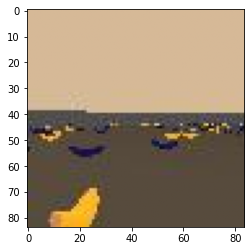

In [17]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]
state =  np.squeeze(state)

plt.imshow(state);

state_torch = torch.from_numpy(state.T).float()
yellow_labels, blue_labels = Auxiliary_network(state_torch)

print(f'yellow labels: {yellow_labels}')
print(f'blue labels: {blue_labels}')

In [20]:
state_torch.size()

torch.Size([3, 84, 84])

In [21]:
aux_net = AuxNet()

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

In [23]:
%%time

aux_net = AuxNet()

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0

while True:
    
    state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
    print(state_torch.size())
    yellow_labels, blue_labels = aux_net(state_torch)
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 84, 84])
torch.Size([3, 8

KeyboardInterrupt: 